*If running in Colab run this first to install ACN-Portal.*

In [1]:
%%script false --no-raise-error
import subprocess
import sys

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    subprocess.check_call([sys.executable, "-m", "pip", "install", "acnportal"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "git+https://github.com/caltech-netlab/adacharge"])

# Baseline Algorithm Evaluation
In this experiment we compare the performance of the Round Robin, First-Come First-Served, Earliest Deadline First, and Least Laxity First algorithms. To understand how these algorithms cope with constrained infrastructure, we limit the capacity of the transformer feeding the charging network. We then compare what percentage of energy demands each algorithm is able to meet. We also consider the current unbalance caused by each algorithm to help understand why certain algorithms are able to deliver more or less energy at a given infrastrucutre capacity.

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pytz
import numpy as np
import pandas as pd
from collections import defaultdict
from pprint import pprint
from copy import deepcopy
import json
import os
import time
import gzip
import random

from acnportal import acnsim
from acnportal import algorithms

from acnportal.acnsim import analysis
from acnportal.signals.tariffs import TimeOfUseTariff

import adacharge

import importlib
importlib.reload(adacharge)

<module 'adacharge' from '/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/adacharge/__init__.py'>

In [3]:
matplotlib.rcParams.update({'font.size': 12})

## Experiment Parameters


In [4]:
# Timezone of the ACN we are using.
timezone = pytz.timezone('Europe/Amsterdam')

# Start and End times are used when collecting data.
start = timezone.localize(datetime(2019, 3, 1))

# Use only one week for quicker results.
end = timezone.localize(datetime(2019, 4, 1,))

# How long each time discrete time interval in the simulation should be.
period = 5  # minutes

# Voltage of the network.
voltage = 208  # volts

# Default maximum charging rate for each EV battery.
default_battery_power =  6.6 # 32 * voltage / 1000 # kW

# Site info
site = 'caltech'
station_ids = acnsim.sites.caltech_acn().station_ids

In [5]:
# Get Events Via the API
API_KEY = os.getenv('API_KEY')
events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, 
                                               period, voltage, 
                                               default_battery_power)

In [6]:
# Save Events
start_iso = start.strftime("%Y%m%dT%H%M%S")
end_iso = end.strftime("%Y%m%dT%H%M%S")
name = f"events/{site}_{start_iso}_{end_iso}_{period}m_{voltage}V_{default_battery_power}kW.json.gz"
if not os.path.exists(name):
    data = events.to_json()
    with gzip.GzipFile(name, 'w') as fout:
        fout.write(json.dumps(data).encode('utf-8'))

In [7]:
# Load Events
start_iso = start.strftime("%Y%m%dT%H%M%S")
end_iso = end.strftime("%Y%m%dT%H%M%S")
name = f"events/{site}_{start_iso}_{end_iso}_{period}m_{voltage}V_{default_battery_power}kW.json.gz"
if os.path.exists(name):
    with gzip.GzipFile(name, 'r') as fin:
        data = json.loads(fin.read().decode('utf-8'))
        events = acnsim.EventQueue.from_json(data)
else:
    print("No cached events with the given parameters.")

/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/acnportal/acnsim/base.py:667: UserWarning: Version 0.3.2 of input acnportal object does not match current version 0.3.3.
  warnings.warn(
/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/acnportal/acnsim/base.py:680: UserWarning: Current version of dependency numpy does not match serialized version. Current: 1.24.4, Serialized: 1.26.0.
  warnings.warn(
/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/acnportal/acnsim/base.py:680: UserWarning: Current version of dependency pandas does not match serialized version. Current: 2.0.3, Serialized: 1.1.5.
  warnings.warn(


## Algorithms
We consider four algorithms: Round Robin, First-Come First-Served, Earliest Deadline First, and Least Laxity First.

In [8]:
def days_remaining_scale_demand_charge(rates, infrastructure, interface,
                                       baseline_peak=0, **kwargs):
    day_index = interface.current_time // ((60 / interface.period) * 24)
    days_in_month = 30
    day_index = min(day_index, days_in_month - 1)
    scale = 1 / (days_in_month - day_index)
    dc = adacharge.demand_charge(rates, infrastructure, interface, baseline_peak, **kwargs)
    return scale * dc

In [9]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['FCFS'] = algorithms.SortedSchedulingAlgo(algorithms.first_come_first_served)
sch['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
sch['EDF'] = algorithms.SortedSchedulingAlgo(algorithms.earliest_deadline_first)
sch['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served)
    
quick_charge_obj = [adacharge.ObjectiveComponent(adacharge.quick_charge),
                    adacharge.ObjectiveComponent(adacharge.equal_share, 1e-12)]
sch['MPC_QC'] = adacharge.AdaptiveSchedulingAlgorithm(quick_charge_obj, solver="ECOS")
sch['Offline_QC'] = adacharge.AdaptiveChargingAlgorithmOffline(quick_charge_obj, solver="ECOS")

cost_min_obj = [adacharge.ObjectiveComponent(adacharge.total_energy, 1000),
                adacharge.ObjectiveComponent(adacharge.tou_energy_cost),
                adacharge.ObjectiveComponent(days_remaining_scale_demand_charge),
                adacharge.ObjectiveComponent(adacharge.quick_charge, 1e-4),
                adacharge.ObjectiveComponent(adacharge.equal_share, 1e-12)
               ]
sch['MPC_CM'] = adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK")

cost_min_obj_off = [
                    adacharge.ObjectiveComponent(adacharge.total_energy, 1000),
                    adacharge.ObjectiveComponent(adacharge.tou_energy_cost),
                    adacharge.ObjectiveComponent(adacharge.demand_charge),
                   ]
sch['Offline_CM'] = adacharge.AdaptiveChargingAlgorithmOffline(cost_min_obj_off, solver="MOSEK")

## Experiment

Load results from the data directory. 

In [10]:
sims = dict()
results_dir = "results/sims"
if os.path.exists(results_dir):
    for filename in os.listdir(results_dir):
        try:
            split_name = filename.split(".")
            if "gz" == split_name[-1]:
                network_type, alg_name, cap = split_name[0].split("-")
                path = os.path.join(results_dir, filename)
                with gzip.GzipFile(path, 'r') as fin:
                    data = json.loads(fin.read().decode('utf-8'))
                    sims[network_type, alg_name, int(cap)] = acnsim.Simulator.from_json(data)
        except ValueError:
            pass

/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:469: UserWarning: Scheduler acnportal.algorithms.sorted_algorithms.RoundRobin requires constructor inputs. Setting scheduler to BaseAlgorithm instead.
  warnings.warn(
/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:469: UserWarning: Scheduler acnportal.algorithms.sorted_algorithms.SortedSchedulingAlgo requires constructor inputs. Setting scheduler to BaseAlgorithm instead.
  warnings.warn(
/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:469: UserWarning: Scheduler adacharge.adacharge.AdaptiveSchedulingAlgorithm requires constructor inputs. Setting scheduler to BaseAlgorithm instead.
  warnings.warn(
/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:469: UserWarning: Scheduler adacharge.adacharge.AdaptiveChargingAlgorithmOffline requires constructor in

### Run Experiment from Scratch

To run the experiment we vary the capacity of the transformer which feeds the Caltech charging network from 5 kW to 150 kW. This allows us to see how each algorithm copes with various levels of infrastructure constraints.

In [11]:
sims = dict()

In [12]:
def run_experiment(network_type, alg_name, cap):            
    if network_type == "single_phase":
        cn = acnsim.sites.simple_acn(station_ids, voltage=voltage, aggregate_cap=cap)
    else:
        cn = acnsim.sites.caltech_acn(basic_evse=True, voltage=voltage, transformer_cap=cap)
    alg = deepcopy(sch[alg_name])
    experiment_events = deepcopy(events)
    signals = {'tariff': TimeOfUseTariff("sce_tou_ev_4_march_2019")}
    sim = acnsim.Simulator(cn, alg, experiment_events, start, period=period, signals=signals, verbose=False)
    print("Running...")
    start_simulation = time.time()
    if alg_name == "Offline_CM" or alg_name == "Offline_QC":
        alg.register_events(experiment_events)
        alg.solve()
    sim.run()
    print(f"Run time: {time.time() - start_simulation}")
    return sim

In [13]:
# We expect Unctrl to overload the system, so we will surpress warnings.
import warnings
warnings.simplefilter("ignore")
    
capacities = list(range(10, 126, 5))
alg_names = ["Unctrl", "FCFS", "EDF", "LLF", "RR", "MPC_CM", "Offline_CM"]
for network_type in ["single_phase", "three_phase"]:
    for cap in capacities:
        for alg_name in alg_names:
            config = (network_type, alg_name, cap)
            print(config)
            if config not in sims:
                sims[config] = run_experiment(*config)

('single_phase', 'Unctrl', 125)
Running...
Run time: 0.46361756324768066
('single_phase', 'FCFS', 125)
Running...
Run time: 0.7278439998626709
('single_phase', 'EDF', 125)
Running...
Run time: 0.6616580486297607
('single_phase', 'LLF', 125)
Running...
Run time: 1.2419519424438477
('single_phase', 'RR', 125)
Running...
Run time: 13.735879182815552
('single_phase', 'MPC_CM', 125)
Running...
Run time: 18.508678197860718
('single_phase', 'Offline_CM', 125)
Running...
Run time: 1.0360329151153564
('three_phase', 'Unctrl', 125)
Running...
Run time: 0.2089216709136963
('three_phase', 'FCFS', 125)
Running...
Run time: 1.1984541416168213
('three_phase', 'EDF', 125)
Running...
Run time: 1.3145065307617188
('three_phase', 'LLF', 125)
Running...
Run time: 1.3033199310302734
('three_phase', 'RR', 125)
Running...
Run time: 80.57572937011719
('three_phase', 'MPC_CM', 125)
Running...
Run time: 48.51488137245178
('three_phase', 'Offline_CM', 125)
Running...
Run time: 4.60791015625


In [25]:
if not os.path.exists("results/sims"):
    os.makedirs("results/sims")
    
for config, sim in sims.items():
    name = "results/sims/{0}-{1}-{2}.json.gz".format(*config)
    if not os.path.exists(name):
        data = sim.to_json()
        with gzip.GzipFile(name, 'w') as fout:
            fout.write(json.dumps(data).encode('utf-8'))

## Results
We can then analyze the results of the experiment. We consider three metrics. 

1.   Proportion of total energy requested which is delivered by each algorithm. 
2.   Maximum infrastructure utilization, defined as the maximum instantaneous power draw over the capacity of the system.
3.   Average current unbalance which measures how well each algorithm is able to balance between phases, a key factor in maximally utilizing infrastructure capacity.

In [26]:
def calc_metrics(config, sim):
    metrics = {
        "Network Type": config[0],
        "Algorithm": config[1],
        "Capacity (kW)": config[2],
        "Energy Delivered (%)": analysis.proportion_of_energy_delivered(sim) * 100,
        "Max Utilization (%)": np.max(analysis.aggregate_power(sim)) / config[2] * 100,
        "Peak (kW)": np.max(analysis.aggregate_power(sim))
    }
    if config[0] == "three_phase":
        metrics["Current Unbalance"] = np.nanmean(analysis.current_unbalance(sim, ['Secondary {0}'.format(p) for p in 'ABC'], 'NEMA'))
    else:
        metrics["Current Unbalance"] = np.nan
    return metrics

In [27]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items())

In [28]:
metrics.groupby(["Algorithm", "Network Type"])["Energy Delivered (%)"].describe()

count       mean  std        min        25%  \
Algorithm  Network Type                                                
EDF        single_phase    1.0  99.990580  NaN  99.990580  99.990580   
           three_phase     1.0  99.990580  NaN  99.990580  99.990580   
FCFS       single_phase    1.0  99.990580  NaN  99.990580  99.990580   
           three_phase     1.0  99.990580  NaN  99.990580  99.990580   
LLF        single_phase    1.0  99.990580  NaN  99.990580  99.990580   
           three_phase     1.0  99.990580  NaN  99.990580  99.990580   
MPC_CM     single_phase    1.0  99.990437  NaN  99.990437  99.990437   
           three_phase     1.0  99.990535  NaN  99.990535  99.990535   
Offline_CM single_phase    1.0  99.990514  NaN  99.990514  99.990514   
           three_phase     1.0  99.990580  NaN  99.990580  99.990580   
RR         single_phase    1.0  99.983204  NaN  99.983204  99.983204   
           three_phase     1.0  99.983204  NaN  99.983204  99.983204   
Unctrl     single_phase    1.0  99.990580  NaN  99.990580  99.990580   
           three_phase     1.0  99.990580  NaN  99.990580  99.990580   

                               50%        75%        max  
Algorithm  Network Type                                   
EDF        single_phase  99.990580  99.990580  99.990580  
           three_phase   99.990580  99.990580  99.990580  
FCFS       single_phase  99.990580  99.990580  99.990580  
           three_phase   99.990580  99.990580  99.990580  
LLF        single_phase  99.990580  99.990580  99.990580  
           three_phase   99.990580  99.990580  99.990580  
MPC_CM     single_phase  99.990437  99.990437  99.990437  
           three_phase   99.990535  99.990535  99.990535  
Offline_CM single_phase  99.990514  99.990514  99.990514  
           three_phase   99.990580  99.990580  99.990580  
RR         single_phase  99.983204  99.983204  99.983204  
           three_phase   99.983204  99.983204  99.983204  
Unctrl     single_phase  99.990580  99.990580  99.990580  
           three_phase   99.990580  99.990580  99.990580

In [29]:
metrics.groupby(["Algorithm", "Network Type"])["Peak (kW)"].describe()

count       mean  std        min        25%  \
Algorithm  Network Type                                                
EDF        single_phase    1.0  77.440000  NaN  77.440000  77.440000   
           three_phase     1.0  77.440000  NaN  77.440000  77.440000   
FCFS       single_phase    1.0  77.440000  NaN  77.440000  77.440000   
           three_phase     1.0  77.440000  NaN  77.440000  77.440000   
LLF        single_phase    1.0  77.440000  NaN  77.440000  77.440000   
           three_phase     1.0  77.440000  NaN  77.440000  77.440000   
MPC_CM     single_phase    1.0  22.920925  NaN  22.920925  22.920925   
           three_phase     1.0  22.920275  NaN  22.920275  22.920275   
Offline_CM single_phase    1.0  19.120549  NaN  19.120549  19.120549   
           three_phase     1.0  19.120545  NaN  19.120545  19.120545   
RR         single_phase    1.0  77.440000  NaN  77.440000  77.440000   
           three_phase     1.0  77.440000  NaN  77.440000  77.440000   
Unctrl     single_phase    1.0  77.440000  NaN  77.440000  77.440000   
           three_phase     1.0  77.440000  NaN  77.440000  77.440000   

                               50%        75%        max  
Algorithm  Network Type                                   
EDF        single_phase  77.440000  77.440000  77.440000  
           three_phase   77.440000  77.440000  77.440000  
FCFS       single_phase  77.440000  77.440000  77.440000  
           three_phase   77.440000  77.440000  77.440000  
LLF        single_phase  77.440000  77.440000  77.440000  
           three_phase   77.440000  77.440000  77.440000  
MPC_CM     single_phase  22.920925  22.920925  22.920925  
           three_phase   22.920275  22.920275  22.920275  
Offline_CM single_phase  19.120549  19.120549  19.120549  
           three_phase   19.120545  19.120545  19.120545  
RR         single_phase  77.440000  77.440000  77.440000  
           three_phase   77.440000  77.440000  77.440000  
Unctrl     single_phase  77.440000  77.440000  77.440000  
           three_phase   77.440000  77.440000  77.440000

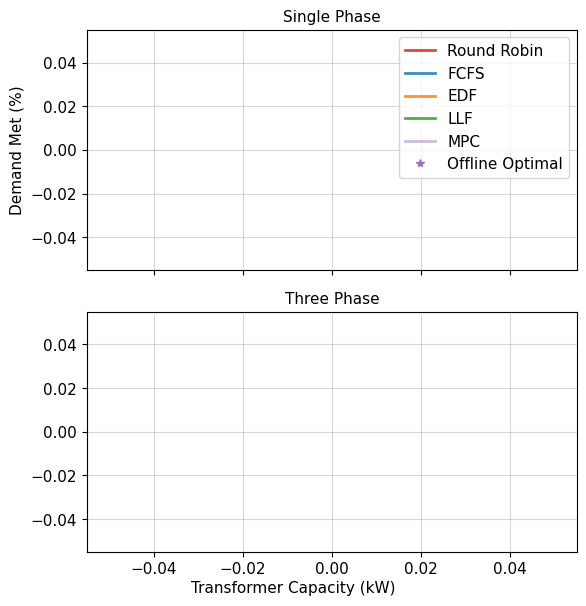

In [30]:
from matplotlib import cm
 
plt.style.use('default')

energy_delivered= metrics.pivot_table("Energy Delivered (%)", "Capacity (kW)", ["Network Type", "Algorithm"])
energy_delivered.rename(columns={'RR': 'Round Robin', 'MPC_CM': 'MPC', 'Offline_CM': 'Offline Optimal'}, inplace=True)

column_order = ['Round Robin', 'FCFS', 'EDF', 'LLF', 'MPC','Offline Optimal']
cap_range = (10, 100)

cmap = cm.get_cmap('tab20')
li = 0
label2color = {'FCFS': cmap(0+li), 'EDF': cmap(2+li), 'LLF': cmap(4+li), 'Round Robin': cmap(6+li), 
               'Offline Optimal': cmap(8), 'MPC': cmap(9)}

style = {
    "color": [label2color[col] for col in column_order],
    "style": ["-"]*5 + ["*"],
    "linewidth": 2,
    "alpha": .85,
    #"marker": ["."]*5 + [None],
    #"fillstyle": "none",
    "legend": False,
}

plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 11})

# fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
energy_delivered["single_phase"][column_order].loc[cap_range[0]:cap_range[1]].plot(ax=ax[0], **style)
energy_delivered["three_phase"][column_order].loc[cap_range[0]:cap_range[1]].plot(ax=ax[1], **style)
ax[0].legend(loc="best")
# pm[:105].plot(color=colors, style=styles, linewidth=4, alpha=0.85)

ax[0].set_title("Single Phase", fontsize=11)
ax[1].set_title("Three Phase", fontsize=11)

fig.text(0.5, 0, "Transformer Capacity (kW)", ha='center')

ax[0].set_xlabel("")
ax[1].set_xlabel("")

ax[0].set_ylabel("Demand Met (%)")

ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.tight_layout()

In this figure we can see that with enough infrastructure capacity, all algorithms are able to meet 100% of demand. Since these requests were taken from real charging data, they are all feasible (meaning with enough capacity we should be able to meet them), so this is to be expected. 



The most interesting range, however, in when infrastructure is moderately constrained, in this case between 20-75 kW. In this range we see that algorithms which use information about departure times and energy demands (EDF and LLF) preform significantly better than those that do not (FCFS and RR). 



Another interesting, but less practical range of operation is the highly constrained regime. Here we see that RR outperforms the other algorithms. To see why we consider the infrastructure utilization plot below.


https://github.com/pandas-dev/pandas/issues/11520

In [31]:
from importlib import reload 
import pandas as pd
reload(pd)

<module 'pandas' from '/home/floris/miniforge3/envs/acn_py38/lib/python3.8/site-packages/pandas/__init__.py'>

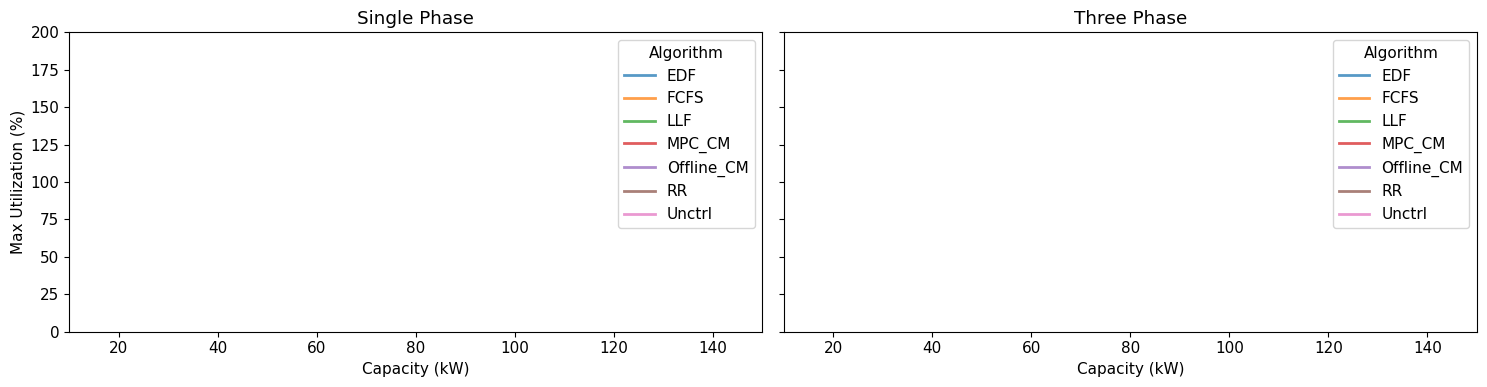

In [32]:
utilization = metrics.pivot_table("Max Utilization (%)", "Capacity (kW)", ["Network Type", "Algorithm"])
fig, axes = plt.subplots(1,2, figsize=(15, 4), sharey=True)
utilization["single_phase"].plot(linewidth=2, alpha=0.75, ax=axes[0])
utilization["three_phase"].plot(linewidth=2, alpha=0.75, ax=axes[1])
axes[0].set_xlim(10, 150)
axes[1].set_xlim(10, 150)

axes[0].set_ylim(0, 200)
axes[1].set_ylim(0, 200)

axes[0].set_ylabel('Max Utilization (%)')
axes[0].set_title("Single Phase")
axes[1].set_title("Three Phase")

plt.tight_layout()

From this plot we can see that RR does a much better job at utilizing constrained infrastructure capacity (in terms of maximum utilization) than the other algorithms. To see why, we can examine the phase unbalance plot below. 

*Note that with high enough capacity, the max utilization for all algorithms converges. This is because there is only so much instantaneous demand in the underlying requests.*

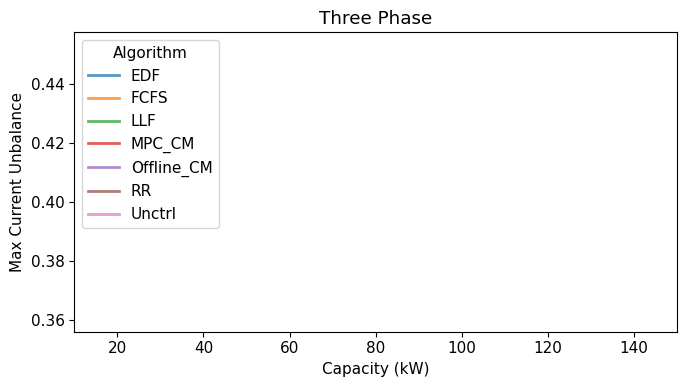

In [33]:
current_unbalance = metrics.pivot_table("Current Unbalance", "Capacity (kW)", ["Network Type", "Algorithm"])
fig, ax = plt.subplots(1, figsize=(7, 4), sharey=True)
current_unbalance["three_phase"].plot(linewidth=2, alpha=0.75, ax=ax)
ax.set_xlim(10, 150)
ax.set_ylabel("Max Current Unbalance")
ax.set_title("Three Phase")
plt.tight_layout()

Here we see that RR acheive much lower average current unbalance than the other algorithms, esspecailly at low infrastructure capacity. By balancing between phases RR is able to deliver power matching the capacity of the network as seen above. However, the other sorting based algorithms do not do as well balancing between phases, leading them to underutilize infrastructure capacity even when there are EVs present which could charge. 

*Note that with sufficient infrastructure capacity, all algorithms have the same average current unbalance. This is becasue the unbalance is inheriant in the demands, i.e. more energy was requested on phase A than on phase B or C.*


This explains why RR is able to deliver more energy with highly constrained infrastructure. When infrastructure is less constrained, however, RR's shortcomings in not accounting for energy demands and departure times means that some EVs are fully charged before their deadline while others leave unsatisfied. This motivates us to examine algorithms which both balance between phases and account for session information such as the adaptive scheduling algorithm presented [here](https://ieeexplore.ieee.org/document/8587550).

## Additional Visualizations

### Line Currents

ACN-Sim also allows us to take a deeper dive into the currents in our simulations. Here we visualize the line currents on the primary and secondary side of the transformer feeding the Caltech ACN for each algorithm. 

In [34]:
def plot_line_currents(sims, names, start, length):
  fig, axes = plt.subplots(2, len(sims), sharey='row', sharex=True, figsize=(16, 6))
  axes[0,0].set_xlim(start, start+length)
  fig.subplots_adjust(wspace=0.07, hspace=0.07)
  for i, sim in enumerate(sims):
    cc = analysis.constraint_currents(sim)
    for line in 'ABC': 
      axes[0, i].plot(cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), linewidth=2)
      axes[1, i].plot(cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), linewidth=2)

    axes[1, i].axhline(416.67/3, color='gray', linestyle='--')
    axes[0, i].axhline(180.5/3, color='gray', linestyle='--')
    axes[0, i].set_title(names[i])
    
  axes[0,-1].legend()
  axes[1,-1].legend()
  plt.show()
  return fig

In [35]:
alg_order = ["Unctrl", "FCFS", "EDF", "LLF", "RR", "MPC_CM", "Offline_CM"]
fig = plot_line_currents([sims["three_phase", alg, 50] for alg in alg_order], alg_order, 84, 180)

KeyError: ('three_phase', 'Unctrl', 50)

### EV Charging Profile

ACN-Sim also allows us to examine the charging rates of a particular EV with each algorithm.

In [36]:
def plot_ev_charging(sim, ev, ax, label, label_auto_place=False):
    evse_index = sim.network.station_ids.index(ev.station_id)
    session_len = ev.departure - ev.arrival
    x = [sim.start + timedelta(minutes=5 * ev.arrival) + timedelta(minutes=5*i) for i in range(session_len)]
    ax.step(x, sim.charging_rates[evse_index][ev.arrival:ev.departure],
            label=label, linewidth=2)
    if label_auto_place:
        ax.legend()
    else:
        ax.text(0.02, 0.9, label, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

def plot_profiles(sims, network_type, cap, ev, end=None, label_auto_place=False):
    fig, axes = plt.subplots(6, 1, sharey=True, sharex=True, figsize=(6, 6))

    x_min = sim.start + timedelta(minutes=5 * ev.arrival)
    x_max = end if end is not None else sim.start + timedelta(minutes=5 * ev.departure)
    axes[0].set_xlim(x_min, x_max)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()

    axes[0].set_ylim(0, 45)
    axes[0].set_yticks([0, 32])
    
    plt.subplots_adjust(hspace=.2)
    fig.text(0.035, 0.55, 'Charging Current (A)', va='center', rotation='vertical')
    print(ev.session_id)
    for i, alg_name in enumerate(["RR", "FCFS", "EDF", "LLF", "MPC", "Offline"]):
        label = alg_name if alg_name != "Offline" else "Offline Optimal"
        plot_ev_charging(sims[network_type, alg_name, cap], ev, axes[i], label=label, label_auto_place=label_auto_place)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
    return fig

Plot charging profiles for session '2_39_78_360_2019-03-05 18:22:15.939445' which highlights the difference between the algorithms. 

In [37]:
# ev = sims[network_type, "RR", cap].ev_history['2_39_78_360_2019-03-05 18:22:15.939445']
# end =  timezone.localize(datetime(2019, 3, 5, 15)
ev = sims[network_type, "RR", cap].ev_history['2_39_129_17_2019-03-02 16:04:30.975643']
end = datetime(2019, 3, 26, 22)
# end = None
network_type = "three_phase"
cap = 50
fig = plot_profiles(sims, network_type, cap, ev, end)

KeyError: '2_39_129_17_2019-03-02 16:04:30.975643'

In [38]:
fig.savefig(f"figures/profiles_{ev.session_id}.pdf", dpi=300)
fig.savefig(f"figures/ev_charging_profiles_2.pdf", dpi=300)

NameError: name 'ev' is not defined

Plot a random EV's profile to see how the algorithms compare for different sessions.

2_39_130_31_2019-03-01 22:13:25.653198


KeyError: ('three_phase', 'RR', 50)

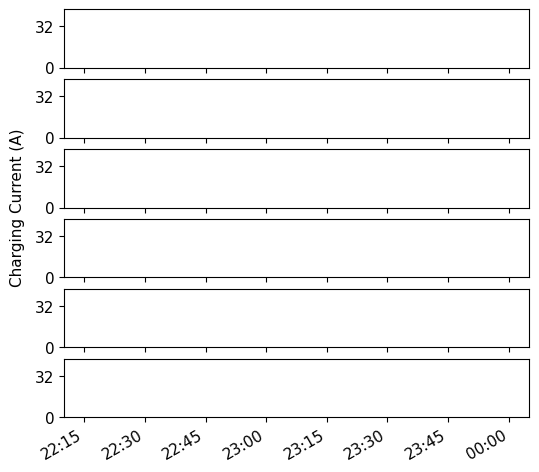

In [39]:
ev = random.choice(list(sims[network_type, "RR", cap].ev_history.values()))
network_type = "three_phase"
cap = 50
plot_profiles(sims, network_type, cap, ev, label_auto_place=True)
plt.show()